In [1]:
import train

number of parameters: 0.000033 M 
step 0: train loss 0.4290, val loss 0.3962
step 10: train loss 0.4163, val loss 0.3980
step 20: train loss 0.3872, val loss 0.3819
step 30: train loss 0.3357, val loss 0.3258
step 40: train loss 0.2994, val loss 0.2995
step 50: train loss 0.1910, val loss 0.1970
step 60: train loss 0.1430, val loss 0.1709
step 70: train loss 0.1315, val loss 0.1622
step 80: train loss 0.1308, val loss 0.1556
step 90: train loss 0.1181, val loss 0.1346
step 100: train loss 0.1027, val loss 0.1279
step 110: train loss 0.0957, val loss 0.1195
step 120: train loss 0.1191, val loss 0.1349
step 130: train loss 0.0914, val loss 0.1118
step 140: train loss 0.1189, val loss 0.1465
step 150: train loss 0.0864, val loss 0.1039
step 160: train loss 0.1012, val loss 0.1129
step 170: train loss 0.0864, val loss 0.1078
step 180: train loss 0.0848, val loss 0.1065
step 190: train loss 0.1055, val loss 0.1216
step 200: train loss 0.0977, val loss 0.1181
step 210: train loss 0.0839, val

In [2]:
model_name = f"heads{train.n_head}_embed{train.n_embd}_no_act"
dataset_name = "regress_gaussian"
num_epochs = train.num_epochs
is_save = False

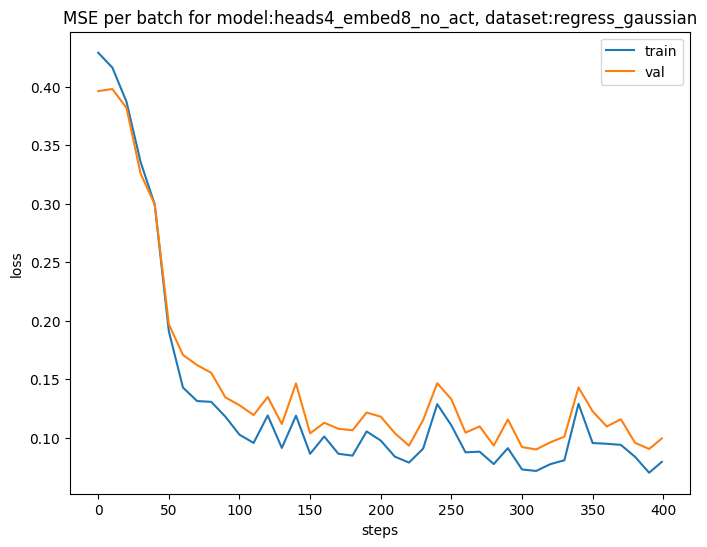

In [3]:
from draw import draw_loss
draw_loss(
    train.iter_list,
    train.train_losses, 
    train.val_losses, 
    f"MSE per batch for model:{model_name}, dataset:{dataset_name}", 
    is_save=is_save
)

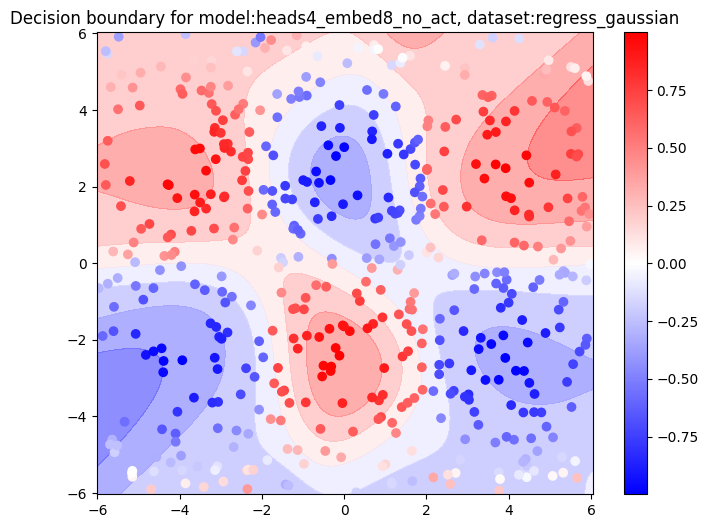

In [4]:
from draw import draw_dataset, draw_decision_boundary
# draw_dataset(train.valset, "Validation set")
draw_decision_boundary(
    train.model, 
    train.valset, 
    f"Decision boundary for model:{model_name}, dataset:{dataset_name}", 
    is_save=is_save
)

In [5]:
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
import matplotlib.pyplot as plt

In [6]:
dataset = train.valset
h = 0.02
x_min, x_max = dataset.x.min() - .05, dataset.x.max() + .05
y_min, y_max = dataset.y.min() - .05, dataset.y.max() + .05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

X = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
print(X.shape, xx.shape, yy.shape)

torch.Size([364816, 2]) (604, 604) (604, 604)


In [7]:
batch_size = 64
embed = torch.zeros(X.shape[0], train.n_embd)
embed_att = torch.zeros(X.shape[0], train.n_embd)
Z = torch.zeros(X.shape[0], 1)
for i in range(0, X.shape[0], batch_size):
    end = min(i + batch_size, X.shape[0])
    batch_x = X[i:end]
    embed_tmp = train.model.embed(batch_x)
    embed[i:end] = embed_tmp
    embed_tmp = rearrange(embed_tmp, 'B (nh hs) -> B nh hs', nh=train.n_head)
    attention = F.scaled_dot_product_attention(embed_tmp, embed_tmp, embed_tmp)
    attention = rearrange(attention, 'B nh hs -> B (nh hs)')
    embed_att[i:end] = attention
    Z[i:end] = train.model(batch_x)

Z = Z.reshape(xx.shape)
embed = rearrange(embed, '(h w) d -> d h w', h=xx.shape[0])
embed_att = rearrange(embed_att, '(h w) d -> d h w', h=xx.shape[0])

In [8]:
print(embed.shape, embed_att.shape, Z.shape)

torch.Size([8, 604, 604]) torch.Size([8, 604, 604]) torch.Size([604, 604])


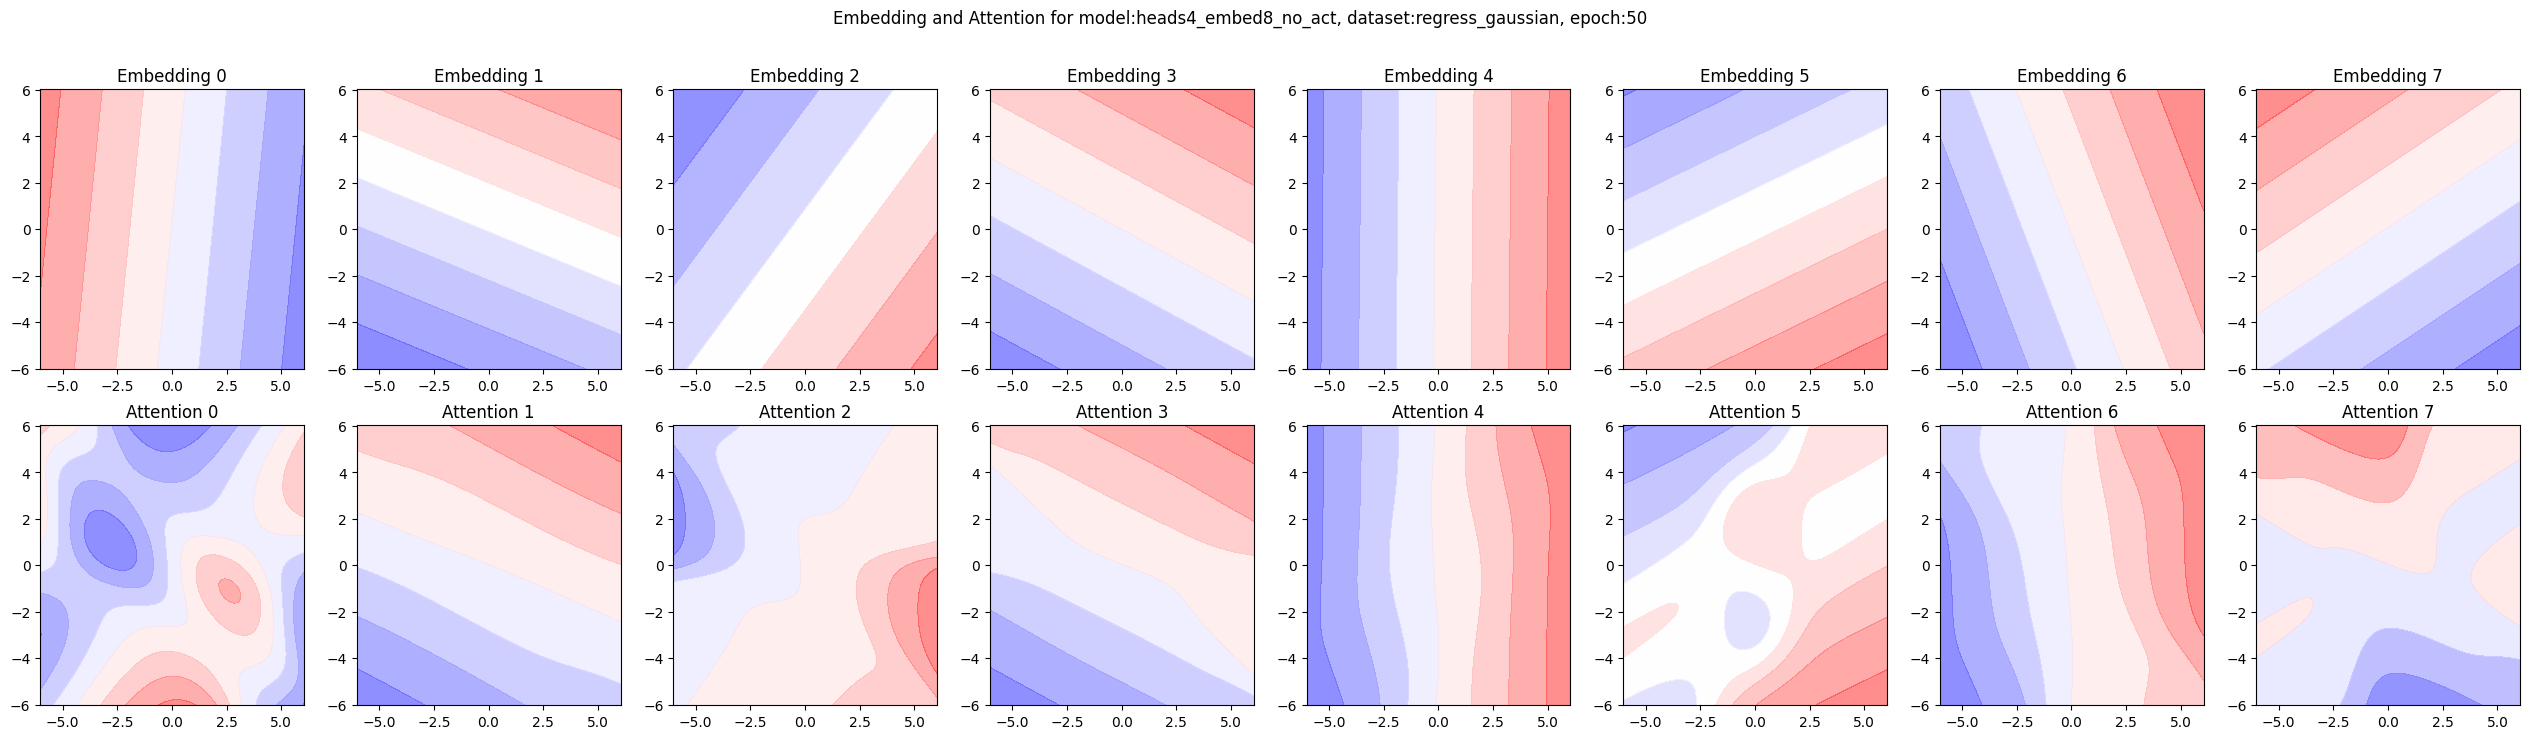

In [12]:
fig, axs = plt.subplots(2, train.n_embd, figsize=(4 * train.n_embd, 8))
for i in range(train.n_embd):
    axs[0, i].contourf(xx, yy, embed[i].detach().numpy(), cmap=plt.cm.bwr, alpha=0.5)
    # axs[0, i].scatter(dataset.x, dataset.y, c=dataset.label, cmap=plt.cm.bwr)
    axs[0, i].set_title(f"Embedding {i}")
    axs[1, i].contourf(xx, yy, embed_att[i].detach().numpy(), cmap=plt.cm.bwr, alpha=0.5)
    # axs[1, i].scatter(dataset.x, dataset.y, c=dataset.label, cmap=plt.cm.bwr)
    axs[1, i].set_title(f"Attention {i}")
plt.suptitle(f"Embedding and Attention for model:{model_name}, dataset:{dataset_name}, epoch:{num_epochs}")
# plt.savefig(f"{model_name}_{dataset_name}_{num_epochs}_embed_att.png")
plt.show()

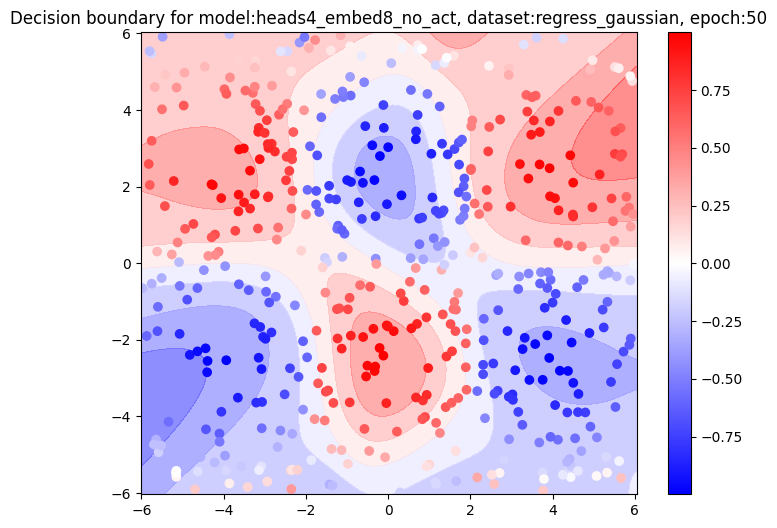

In [13]:
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z.detach().numpy(), cmap=plt.cm.bwr, alpha=0.5)
plt.scatter(dataset.x, dataset.y, c=dataset.label, cmap=plt.cm.bwr)
plt.title(f"Decision boundary for model:{model_name}, dataset:{dataset_name}, epoch:{num_epochs}")
plt.colorbar()
# plt.savefig(f"{model_name}_{dataset_name}_{num_epochs}_decision_boundary.png")
plt.show()